# Topic Modelling and Bot Detection on Twitter
## An Investigation into the Online Discourse over Oil & Gas Development

## The Strategy
    1. Capture a large (enough) dataframe of relevant tweets using Tweepy to search by hashtag.
    2. Perform Topic Modelling with Gensim LDA.
    3. Perform K-Means Clustering on relevant features to detect bots.
    4. Plot the outcomes.

Note: The topic modelling and bot detection are done independently of eachother. These are two claffication models that do not interact.

To start, let's import the necessary libraries.

In [354]:
# For reading the API data
import requests
import json
import csv

# -THE- API
import tweepy

#Some basics to build our functions.
import numpy as np
import pandas as pd
from datetime import datetime, timezone
import pytz
import time
import re

#Visualization tools
import matplotlib.pyplot as plt
import plotly.express as px

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

#Text cleaning
import sklearn.feature_extraction.text as text
import nltk
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
import string

#Clustering
from sklearn.cluster import KMeans
import Levenshtein
from Levenshtein import distance

Need to put in my secret keys (you can use them, just shhhhh its a secret)

In [309]:
#Daily Authentication

consumer_key = 'wQnRRThsArRe58k7HeZizenTC' #Twitter Keys
consumer_secret = 'QkaTAM6JvyA3I6BHhdDFwlDT2WoJWdr78pGNlDZxDXaHjF6rJO'
access_token = '1317183074921287682-StGbFvdz2UOXazlWNWjpVkcurUXaYu'
access_token_secret='FMhAEz5bdytuVGYpWASTqaZLLRnI0p8VxsMUzhh8fChul'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

## Functions for data cleaning

Seems weird to start here, but I run this function in the function when I build the dataframe/collect tweets.

Twitter is awful noise garbage. While a wiser man might be able to utilize emojis and images to build a stronger model, I am not that man. We will perform a simple data cleaning process which is typical of LDA:

1. Remove URLs/tags/hashtags
2. Define and remove stopwords
3. Tokenize tweets
4. Lemmanize words.

In [379]:
#Needed a million functions for text cleaning
def remove_tags(df):
    df =  re.sub(r'@\S+', '', df)
    return df

def remove_hash(df):
    df =  re.sub(r'#', '', df)
    return df

def remove_urls(df):
    df = re.sub(r'http\S+', '', df)
    return df

def tokenize_me(text):
    stop_words = stopwords.words('english')
    stop_words += list(string.punctuation)
    stop_words += ['#','!', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '19', '...', '. . .', '…', 'rt', "’", "“", 'keystonexl','energyeast', 'transmountain', 'oilandgas', 'northerngateway', 'tmx', 'oilsands', 'lnginbc', 'albertaoil', 'coastalgaslink','cdnpoli', 'ableg', '#bcpoli']
    token = TweetTokenizer()
    tokens = token.tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if not token.lower() in stop_words]
    return stopwords_removed

def lemmatize_text(df_text):
    lemmatizer = WordNetLemmatizer()
    lemmatized =[]
    for w in df_text:
        lemmatized.append(lemmatizer.lemmatize(w))
    return lemmatized


## Tweepy Api and Functions

We will start by building functions to gather relevant information. I also included prepping the dictionary/text_bow within the main function. One nice dataframe.

In [170]:
#Create a DataFrame of relevant features from those who reply to a select user.
def create_df_hash(api, hashes):
    flag = False
    temp_df = pd.DataFrame()
    data = []
    for hashtag in hashes:
        
        if flag:
            print('I sleep now, come back in 16 mins', datetime.now())
            time.sleep(60*16)
            print('Back at it')

        for tweet in tweepy.Cursor(api.search, q=hashtag + '-filter:retweets', tweet_mode='extended').items(2000):
            tweet_details = {}
            tweet_details['id'] = tweet.user.id
            tweet_details['name'] = tweet.user.name
            tweet_details['text'] = tweet.full_text
            tweet_details['retweet_count'] = tweet.retweet_count
            tweet_details['tweets_count'] = tweet.user.statuses_count
            tweet_details['location'] = tweet.user.location
            tweet_details['created'] = tweet.created_at
            tweet_details['followers'] = tweet.user.followers_count
            tweet_details['friends'] = tweet.user.friends_count
            tweet_details['is_user_verified'] = tweet.user.verified
            data.append(tweet_details)
        flag = True
    temp_df = temp_df.append(data)
    return temp_df.reset_index()

With that out of the way, let's build the dataframe. This function will take forever. I've commented-out the function so that you can instead pull the data from a saved csv.

In [ ]:
## Save time by taking the data from a csv.
# df = pd.read_csv('Data')

In [397]:
hashes = ['KeystoneXL','EnergyEast', 'TransMountain', '#TMX', 'NorthernGateway', 'LNGinBC', 'CoastalGasLink', '#ethicaloil']

df = create_df_hash(api, hashes)

## Topic Modelling

Alright, so let's get to it. Everything below is fairly straightforward with a few caveats. I made a function to append the most likely topic to the dataframe for visualization.

In [452]:
text_frame = df.text # pick the column for topic modelling

#Prep for LDA
text_frame = text_frame.apply(remove_urls)   
text_frame = text_frame.apply(remove_tags) 
text_frame = text_frame.apply(remove_hash)   
text_frame = text_frame.apply(tokenize_me)

text_frame = text_frame.apply(lemmatize_text)
text_dict = Dictionary(text_frame)
text_dict.filter_extremes(no_below=2, no_above=.99)
tweets_bow = [text_dict.doc2bow(tweet) for tweet in text_frame]


## Quick Check:

Before we settle on a model, lets take what we have and determine an appropriate number of topics by ploting the coherence scores. Warning: this takes forever.

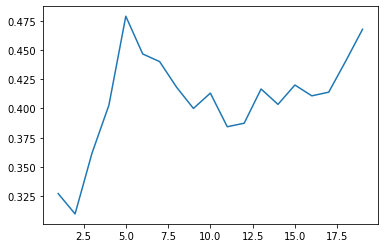

In [399]:
def coherence_plot(tweets_bow, text_dict):
    k_values = []
    coherence_values = []

    for i in range(1,20):
        tweets_lda =  LdaModel(tweets_bow,
                        num_topics = i,
                        id2word = text_dict,
                        random_state = 1,
                        passes=1)
        cm = CoherenceModel(model=tweets_lda, corpus=tweets_bow, texts=text_frame, dictionary=text_dict)
        k_values.append(i)
        coherence_values.append(cm.get_coherence())
    return k_values,coherence_values

k_list, c_list = coherence_plot(tweets_bow, text_dict)
plt.plot(k_list, c_list)


Alright, let's do this.

In [453]:
tweets_lda =  LdaModel(tweets_bow,
                    num_topics = 4,
                    id2word = text_dict,
                    random_state = 1,
                    passes=10)
df['Tweets_bow'] = tweets_bow

# Let's quickly get a read on these
words = [re.findall(r'"([^"]*)"',t[1]) for t in tweets_lda.print_topics()]
topics = [' '.join(t[0:10]) for t in words]

for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

cm = CoherenceModel(model=tweets_lda, corpus=tweets_bow, texts=text_frame, dictionary=text_dict)

------ Topic 0 ------
pipeline canada bc would apartheid indigenous know mountain canada's era

------ Topic 1 ------
china pipeline canada un deal job car buying tie shut

------ Topic 2 ------
pipeline canada oil would u stoptmx keystone biden gas job

------ Topic 3 ------
pipeline project worker march canada indigenous gas action could transition



## Bot Detection with K-Means Clustering

I tried several methods and found the most success with the metrics identified in Alex Hai Wang's paper (https://link.springer.com/content/pdf/10.1007%2F978-3-642-13739-6_25.pdf). As this project neccessitates unsupervised methods, we will use K-Means clustering. The metrics used will include:

1. The follower/friends ratio
2. Levenstein distance between tweets
3. number of links used in tweets
4. number of hashtags in tweets

While the accuracy of detecting 'bots' with this method is debateable, our clusters will certainly capture spammy-accounts with minimal interactions aside from mass tweeting copy-and-pasted ideas.

### Retrieve Twitter User information.

In [401]:
#You can skip this step, the dataset below holds the captured features.
df = pd.read_csv(r'C:\Users\David\Documents\code\Mod_4\4-9-clustering-project\Final_Data')

#Pull twenty recent tweets and metadata from user id
def collect_tweets(nit_twit):
    temp_df = pd.DataFrame()
    temp_list = []

    try:
        tweets = api.user_timeline(nit_twit, tweet_mode="extended")
    except:
        return {'more_tweets':'none', 'hash_count':0, 'url_count':0}
    for tweet in tweets:
        hashcount = 0
        urlcount = 0
        tweet_details = {}

        tweet_details['full_text'] = tweet.full_text
        tweet_details['full_text'] = remove_urls2(tweet_details['full_text'])
        tweet_details['full_text'] = remove_tags2(tweet_details['full_text'])

        for i in tweet.entities['hashtags']:
            hashcount += 1
        for i in tweet.entities['urls']:
            urlcount += 1

        tweet_details['hashtags'] = hashcount
        tweet_details['urls'] = urlcount
        temp_list.append(tweet_details)
    
    temp_df = temp_df.append(temp_list,ignore_index=True)
    final_list = []

    final_dict = {}
    final_dict['id'] = nit_twit

    for i in temp_df.full_text:
        final_list.append(i)
    final_dict['more_tweets'] = pd.Series(final_list)
    final_dict['hash_count'] = sum(temp_df.hashtags / len(temp_df.hashtags))
    final_dict['url_count'] = sum(temp_df.urls / len(temp_df.urls))
    return final_dict

# Follower/friend ratio:
df['follower_ratio'] = df.followers / (df.followers + df.friends)

#For the other metrics, we will use the identified function to pull more tweets and metadata:
df_ = pd.DataFrame()
for i in range(len(df.index)):
    df_ = df_.append(collect_tweets(df.id[i]), ignore_index=True)

df = df.merge(df_, on='id')

Rate limit reached. Sleeping for: 267


### Build features

In [ ]:
#Levenstein distance:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def lev_average(text_list):
    dist_list = []
    for i in range(len(text_list)):
        for j in range(len(text_list) - 1):
            if text_list[i] == text_list[j]:
                continue
            else:
                dist_list.append(fuzz.ratio(text_list[i], text_list[j]))
    try:
        return (sum(dist_list)/len(dist_list))
    except:
        return 0
        
df['lev_dist'] = df.more_tweets.apply(lev_average)

df = df.replace(-np.inf, np.nan)
df = df.dropna()

### Finally, let's cluster!

In [ ]:
kmeans = KMeans(n_clusters=2).fit(df[['follower_ratio', 'lev_dist','url_count', 'hash_count']])
pred = kmeans.predict(df[['follower_ratio', 'lev_dist','url_count', 'hash_count']])

## Dimension Reduction and Visualizations

In [402]:
from sklearn.manifold import TSNE

topic_weights = []
for i, row_list in enumerate(tweets_lda[df['Tweets_bow']]):
    topic_weights.append([w for i, w in row_list])

arr = pd.DataFrame(topic_weights).fillna(0).values

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=3, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3617 samples in 0.017s...
[t-SNE] Computed neighbors for 3617 samples in 0.099s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3617
[t-SNE] Computed conditional probabilities for sample 2000 / 3617
[t-SNE] Computed conditional probabilities for sample 3000 / 3617
[t-SNE] Computed conditional probabilities for sample 3617 / 3617
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 39.878265
[t-SNE] KL divergence after 1000 iterations: -0.674356


In [404]:
vis_df = df

vis_df['x'] = tsne_lda[:, 0]
vis_df['y'] = tsne_lda[:, 1]
vis_df['z'] = tsne_lda[:, 2]
vis_df['c'] = topic_num
vis_df['bot'] = pred

x = vis_df['x'] 
y = vis_df['y']
z = vis_df['z']
c = vis_df['c']
symbol = vis_df['bot']

fig = px.scatter_3d(x=x, z=z, y=y,
              color=c, symbol=symbol)

fig.show()


In [478]:
# Who has the most bots?
vis_df1.groupby(by = ['c']).sum()['bot']

c
0    36
1    33
2    22
3    12
Name: bot, dtype: int32